In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sym
from string import ascii_uppercase
from collections import Counter

## 1D random walk with reflecting and absorbing barriers

- Markov chain
  - State transition diagram

![](https://raw.githubusercontent.com/marsgr6/r-scripts/master/imgs/drunkards-walk.png)

- Transition probability matrix $P$ below

In [43]:
# Transition probability matrix P
n = 4

def make_P(n=4):
    ds = [1] + [0.5]*(n-1)
    Xs = np.diag(ds, 1)
    di = [0.5]*(n-1) + [0]
    Xi = np.diag(di, -1)
    dd = [0]*(n) + [1]
    Xd = np.diag(dd, 0)
    P = Xs+Xi+Xd
    return P

sym.Matrix(make_P())

Matrix([
[  0, 1.0,   0,   0,   0],
[0.5,   0, 0.5,   0,   0],
[  0, 0.5,   0, 0.5,   0],
[  0,   0, 0.5,   0, 0.5],
[  0,   0,   0,   0, 1.0]])

### Analytical solution

- Check: https://en.wikipedia.org/wiki/Absorbing_Markov_chain

In [9]:
I = np.identity(n)
Q = np.matrix(P[0:n,0:n])
IV = np.matrix([1]*n).transpose()
R = np.matrix([0, 0, 0, 0.5]).transpose()

mean_step_from_state_i = np.linalg.inv(I - Q)*IV
mssi = [print("From "+str(i)+" the avg step to reach n is "+str(si)) 
       for i,si in enumerate(mean_step_from_state_i)]

From 0 the avg step to reach n is [[16.]]
From 1 the avg step to reach n is [[15.]]
From 2 the avg step to reach n is [[12.]]
From 3 the avg step to reach n is [[7.]]


### Solution by simulation

- Use the probability transition matrix

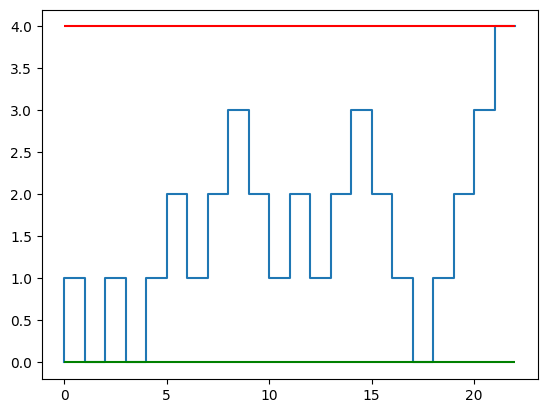

In [45]:
# code here
def make_walk(start, states):
    P = make_P(len(states)-1)
    walk = [start]
    # Use a while because fly will always scape
    while True:
        walk += [np.random.choice(states, p=P[walk[-1]])]
        if walk[-1] == walk[-2]: break
    return walk[:-1]

states = list(range(n+1))
start = 0

walk = make_walk(start, states)

plt.step(range(len(walk)), walk)
plt.hlines(0, 0, len(walk)-1,'g')
plt.hlines(4, 0, len(walk)-1, 'r')

In [35]:
[np.array([len(make_walk(si, states, P))-1 for i in range(10000)]).mean() for si in [0, 1, 2, 3]]

[15.9924, 14.762, 11.7306, 6.9282]

In [47]:
[np.array([len(make_walk(0, states))-1 for i in range(10000)]).mean() for states in [[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6]]]

[9.0558, 15.8796, 25.1604, 36.0354]

## Random shortest path

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Shortest_path_with_direct_weights.svg/1280px-Shortest_path_with_direct_weights.svg.png)

- Find the most common random walks from origin A to target F.
- Use the same logic as our markov chain.

In [48]:
n = 6  # states
states = list(ascii_uppercase[:n])
states

['A', 'B', 'C', 'D', 'E', 'F']

In [49]:
M = np.matrix('0 4 2 0 0 0; 0 0 5 10 0 0; 0 0 0 0 3 0; 0 0 0 0 0 11; 0 0 0 4 0 0; 0 0 0 0 0 1')
M = np.array(M)
MD = pd.DataFrame(M, index = states, columns = states)
MD

,A,B,C,D,E,F
A,0,4,2,0,0,0
B,0,0,5,10,0,0
C,0,0,0,0,3,0
D,0,0,0,0,0,11
E,0,0,0,4,0,0
F,0,0,0,0,0,1


In [52]:
P = [mii/mi.sum() if mii else mii for mi in M for mii in mi]
P = np.array([1-pi if (pi!=0 and pi!=1) else pi for pi in P])
P = P.reshape(n,n)
print(P)

[[0.         0.33333333 0.66666667 0.         0.         0.        ]
 [0.         0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


In [53]:
PD = pd.DataFrame(P, index = states, columns = states)
PD

,A,B,C,D,E,F
A,0.0,0.333333,0.666667,0.000000,0.0,0.0
B,0.0,0.000000,0.666667,0.333333,0.0,0.0
C,0.0,0.000000,0.000000,0.000000,1.0,0.0
D,0.0,0.000000,0.000000,0.000000,0.0,1.0
E,0.0,0.000000,0.000000,1.000000,0.0,0.0
F,0.0,0.000000,0.000000,0.000000,0.0,1.0


In [54]:
start_ = 'A'
target = 'F'

all_walks = []

for i in range(10000):

    walk = [start_]

    while(True):
        walk += [np.random.choice(states, p=PD.loc[walk[-1]])]
        if walk[-1] == target: break
    all_walks += [walk]
C = Counter(str(wi) for wi in all_walks)
C

Counter({"['A', 'C', 'E', 'D', 'F']": 6737,
         "['A', 'B', 'D', 'F']": 1121,
         "['A', 'B', 'C', 'E', 'D', 'F']": 2142})

In [55]:
def get_cost(path):
    return sum([MD[path[i]][path[i-1]] for i in range(1, len(path))])

paths = [Ci[2:-2].split("', '") for Ci in list(C.keys())]

{'-'.join(pi): get_cost(pi) for pi in paths}

{'A-C-E-D-F': 20, 'A-B-D-F': 25, 'A-B-C-E-D-F': 27}

### Appendix: Another example of markov chain

![](https://ds055uzetaobb.cloudfront.net/brioche/uploads/rtH8yftGTb-drunkards-walk.png)

- Transition probability matrix P

In [11]:
P = np.matrix("1 0 0 0 0; 0.5 0 0.5 0 0; 0 0.5 0 0.5 0; 0 0 0.5 0 0.5; 0 0 0 0 1")
P

matrix([[1. , 0. , 0. , 0. , 0. ],
        [0.5, 0. , 0.5, 0. , 0. ],
        [0. , 0.5, 0. , 0.5, 0. ],
        [0. , 0. , 0.5, 0. , 0.5],
        [0. , 0. , 0. , 0. , 1. ]])

- Analytical solution

- Check: https://en.wikipedia.org/wiki/Absorbing_Markov_chain

In [12]:
Q = np.matrix(P[1:4,1:4])
R = np.matrix('0.5 0; 0 0; 0 0.5')
I = np.identity(3)
Isteps = np.matrix([1]*3).transpose()
Q, R, I, Isteps

(matrix([[0. , 0.5, 0. ],
         [0.5, 0. , 0.5],
         [0. , 0.5, 0. ]]),
 matrix([[0.5, 0. ],
         [0. , 0. ],
         [0. , 0.5]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 matrix([[1],
         [1],
         [1]]))

In [13]:
np.linalg.inv(I - Q)*R

matrix([[0.75, 0.25],
        [0.5 , 0.5 ],
        [0.25, 0.75]])

In [14]:
np.linalg.inv(I - Q)*Isteps

matrix([[3.],
        [4.],
        [3.]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6270f206-ff88-4533-afc5-e2a8c2de37fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>